In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:

NUM_FOLD = 5

df = pd.read_csv('../dataset/train.csv', index_col='id')
# train = pd.read_csv('../dataset/train.csv', index_col='id')
# test = pd.read_csv('../dataset/test.csv', index_col='id')
# original = pd.read_csv('../dataset/original.csv')
# sample_submission = pd.read_csv('../dataset/sample_submission.csv')


In [3]:

# # accepted_cols = ['person_income', 'person_home_ownership', 'loan_intent',
# #        'loan_grade', 'loan_int_rate', 'loan_percent_income','loan_status']

# # train = train[accepted_cols]
# # original = original[accepted_cols]
# # accepted_cols.remove("loan_status")
# # test = test[accepted_cols]



# cat_cols = list(test.select_dtypes(include=['object']).columns)

# for df in [train, test, original]:
#     for col in cat_cols:
#         df[col] = df[col].astype('str').astype('category')


# X = train.drop(['loan_status'], axis=1)
# y = train['loan_status']
# X_original = original.drop(['loan_status'], axis=1)
# y_original = original['loan_status']





In [4]:
df['log_person_income'] = np.log1p(df['person_income'])

# ceil all float columns to int after multiplying by 100

for col in df.select_dtypes(include=['float']).columns:
    df[col] = (df[col] * 100).astype(int)
    


In [5]:
import seaborn as sns

# sns.boxplot(x='loan_status', y='log_person_income', data=df)

In [6]:
# sns.histplot(df['log_person_income'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   person_age                  58645 non-null  int64 
 1   person_income               58645 non-null  int64 
 2   person_home_ownership       58645 non-null  object
 3   person_emp_length           58645 non-null  int64 
 4   loan_intent                 58645 non-null  object
 5   loan_grade                  58645 non-null  object
 6   loan_amnt                   58645 non-null  int64 
 7   loan_int_rate               58645 non-null  int64 
 8   loan_percent_income         58645 non-null  int64 
 9   cb_person_default_on_file   58645 non-null  object
 10  cb_person_cred_hist_length  58645 non-null  int64 
 11  loan_status                 58645 non-null  int64 
 12  log_person_income           58645 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 6.3+ MB


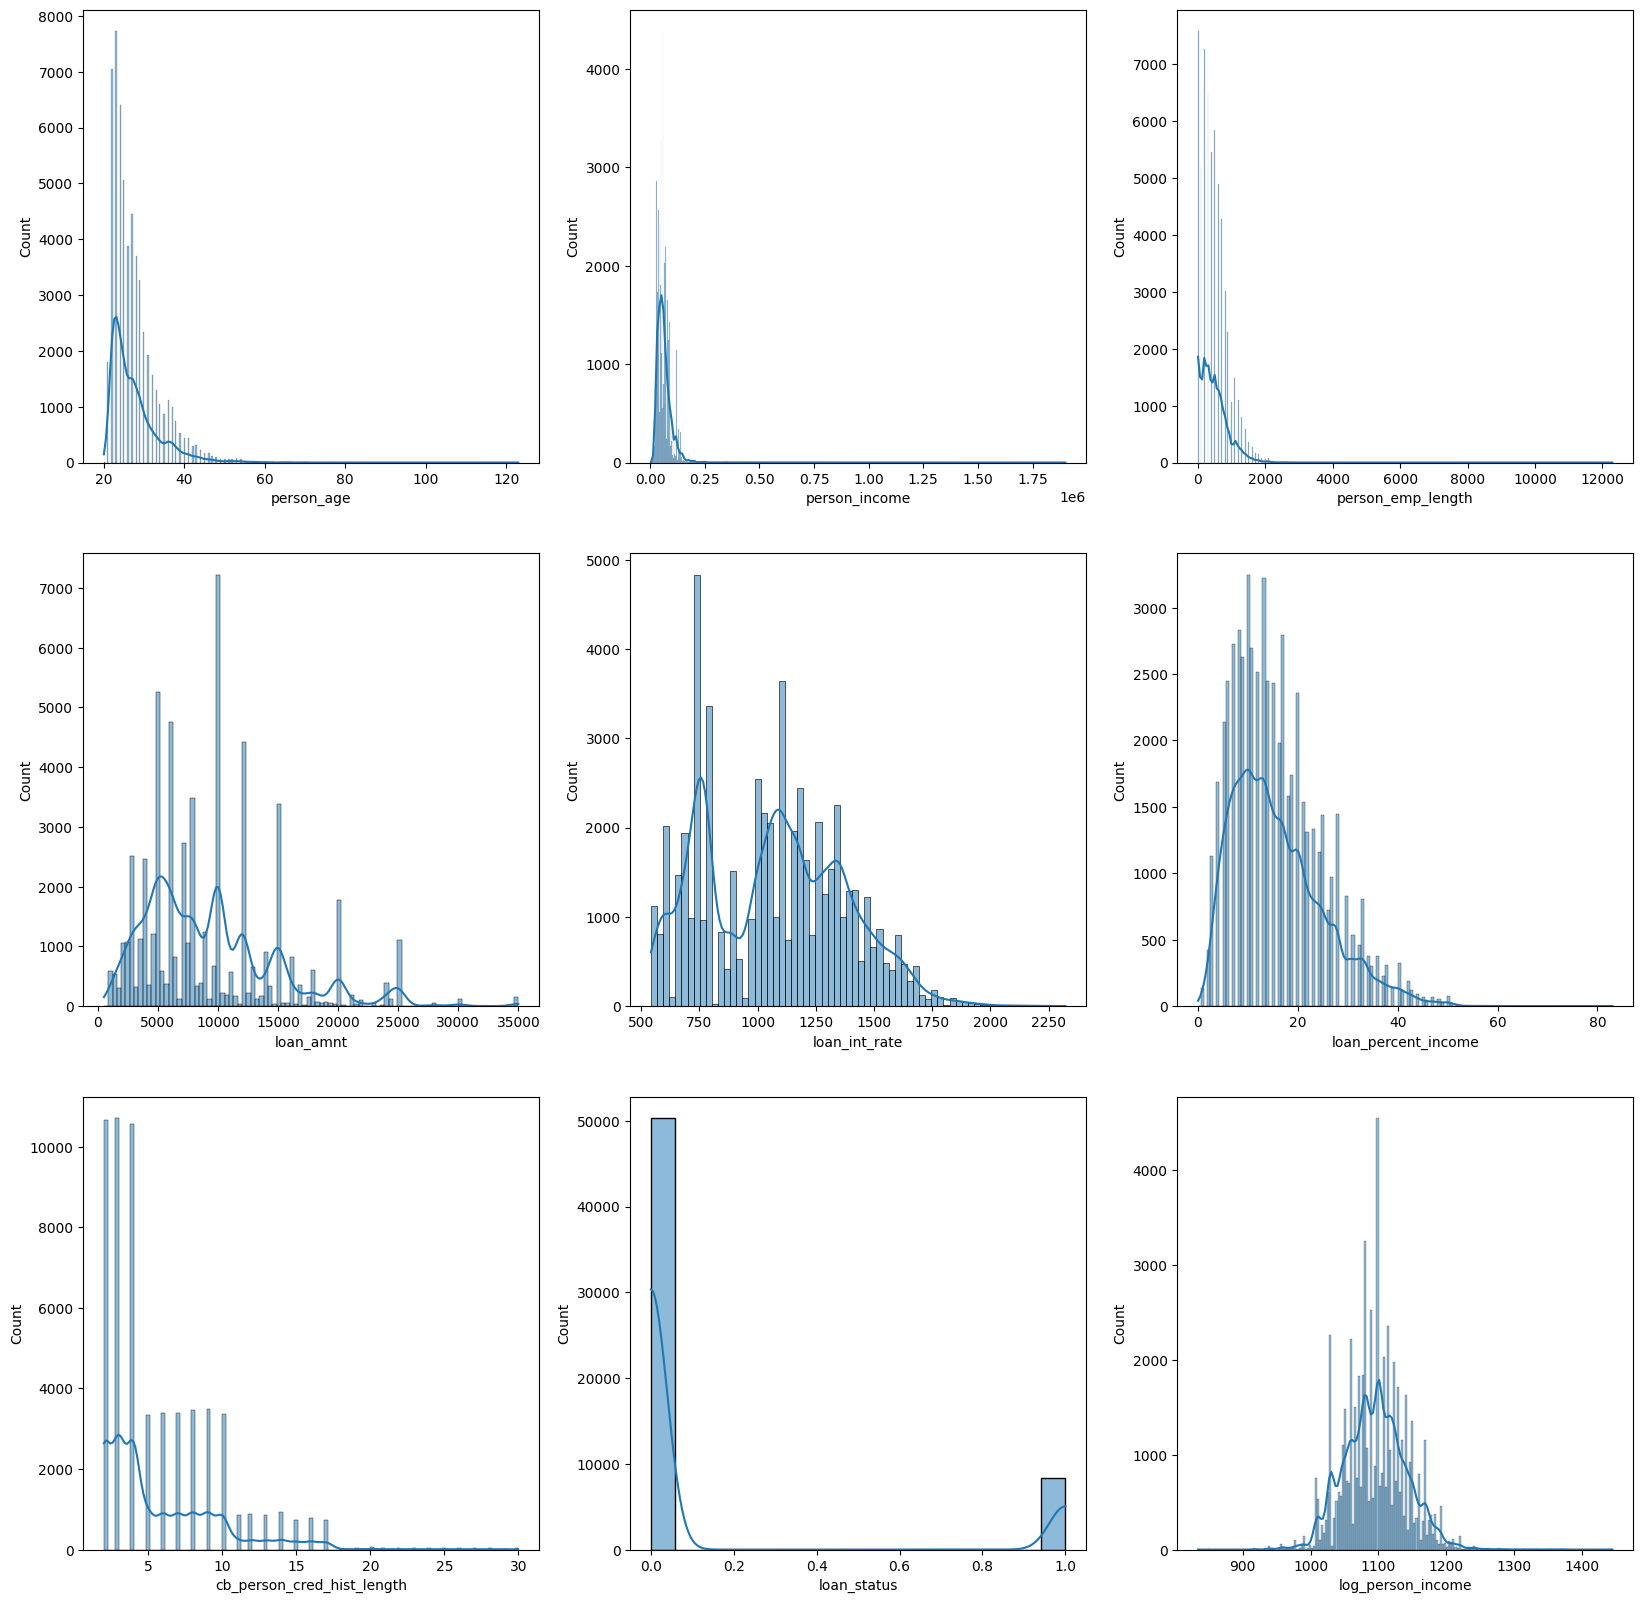

In [7]:
# for col in df.columns:
#     if df[col].dtype != 'object':
#         sns.histplot(df[col])

# draw hist diagram in subplots for each numerical column
num_cols = df.select_dtypes(include=['int64']).columns
fig, axes = plt.subplots((len(num_cols) + 2) // 3, 3, figsize=(20, 20))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i//3, i%3],kde=True)



# person_age, person_income, cb_cred_hist_length, 

In [33]:
for col in df.columns:
    if df[col].dtype != 'object':
        skewness = df[col].skew()
        kurtosis = df[col].kurt()

        print(f'{col}: Skewness: {skewness}, Kurtosis: {kurtosis}')


person_age: Skewness: 1.9654967033657, Kurtosis: 6.408379567393629
person_income: Skewness: 10.457722504927045, Kurtosis: 342.6293525072882
person_emp_length: Skewness: 2.0544297052943943, Kurtosis: 29.131605597935177
loan_amnt: Skewness: 1.1885784743437686, Kurtosis: 1.6937836745265122
loan_int_rate: Skewness: 0.19982318325194234, Kurtosis: -0.7186523535331157
loan_percent_income: Skewness: 0.9190148265495159, Kurtosis: 0.6496885876209366
cb_person_cred_hist_length: Skewness: 1.6185028956126892, Kurtosis: 3.4907748950955466
loan_status: Skewness: 2.0468483311716152, Kurtosis: 2.189662764830158
log_person_income: Skewness: 0.22086210368842457, Kurtosis: 0.8081142389352416


skewness:  1.1982618630463253  kurtosis:  1.5301725877333303


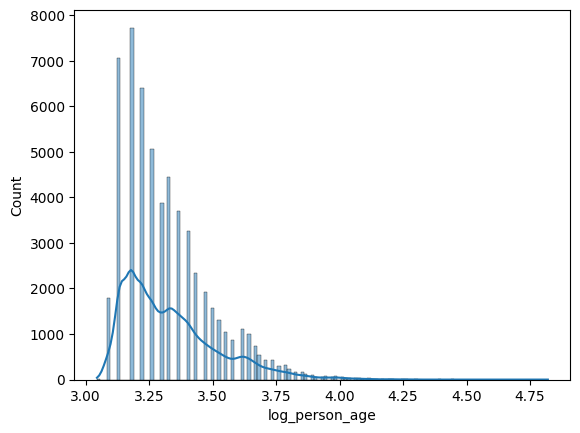

In [35]:
df['log_person_age'] = np.log1p(df['person_age'])
sns.histplot(df['log_person_age'],kde=True)
print("skewness: ",df['log_person_age'].skew() ," kurtosis: ",df['log_person_age'].kurt())

0.1640466910381811 -0.9140041192535011


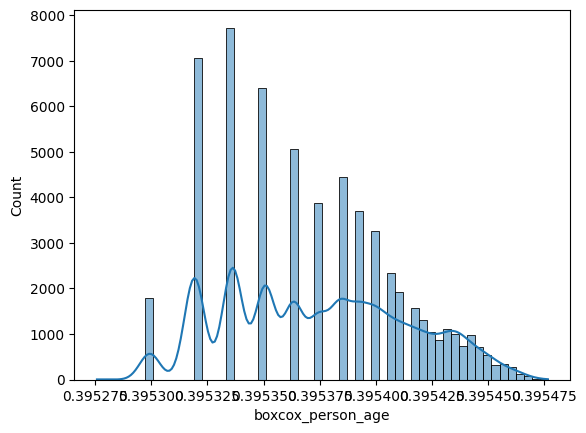

In [37]:
from scipy import stats
df['boxcox_person_age'], _ = stats.boxcox(df['person_age'])
sns.histplot(df['boxcox_person_age'], kde=True)
print(df['boxcox_person_age'].skew(), df['boxcox_person_age'].kurt())


0.1667681938950027 -0.9158257638097926


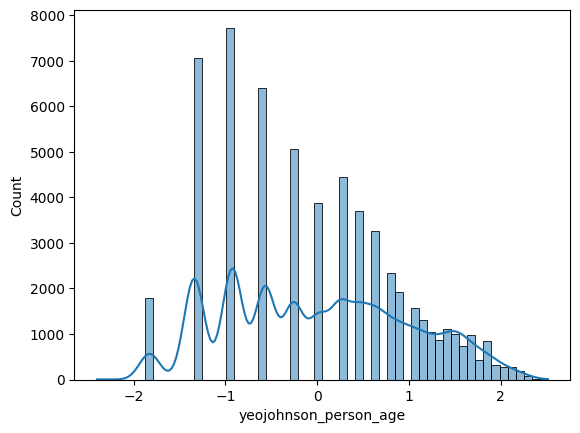

In [38]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df['yeojohnson_person_age'] = pt.fit_transform(df[['person_age']])
sns.histplot(df['yeojohnson_person_age'], kde=True)
print(df['yeojohnson_person_age'].skew(), df['yeojohnson_person_age'].kurt())


0.995439010249065 -0.0016175804504663382


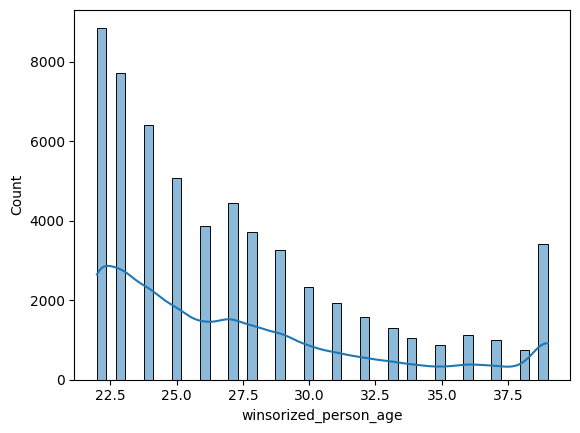

In [39]:
from scipy.stats import mstats
df['winsorized_person_age'] = mstats.winsorize(df['person_age'], limits=[0.05, 0.05])  # Cap extremes
sns.histplot(df['winsorized_person_age'], kde=True)
print(df['winsorized_person_age'].skew(), df['winsorized_person_age'].kurt())


In [43]:
df['binned_person_age'] = pd.qcut(df['person_age'], q=4)  # Quartile binning
# sns.histplot(df['binned_person_age'],kde=True)
# print("skewness: ",df['binned_person_age'].skew() ," kurtosis: ",df['binned_person_age'].kurt())
df['binned_person_age'].value_counts()

binned_person_age
(19.999, 23.0]    16584
(23.0, 26.0]      15336
(26.0, 30.0]      13760
(30.0, 123.0]     12965
Name: count, dtype: int64

In [44]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
df_poly = poly.fit_transform(df[['person_age']])


In [45]:
df_poly

array([[1.000e+00, 3.700e+01, 1.369e+03],
       [1.000e+00, 2.200e+01, 4.840e+02],
       [1.000e+00, 2.900e+01, 8.410e+02],
       ...,
       [1.000e+00, 2.300e+01, 5.290e+02],
       [1.000e+00, 2.200e+01, 4.840e+02],
       [1.000e+00, 3.100e+01, 9.610e+02]])

In [46]:
def handle_skewness(df,col):
    name = "log"+ col
    df[name] = np.log1p(df[col])
    print("skewness: ",df[name].skew() ," kurtosis: ",df[name].kurt())
    sns.histplot(df[name],kde=True)


skewness:  0.2218430047264499  kurtosis:  0.8138128783039016


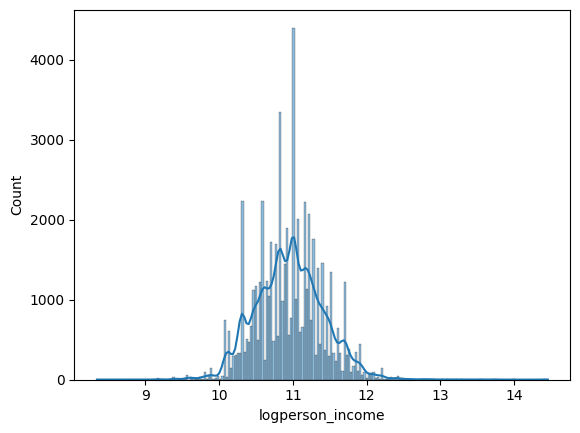

In [47]:
handle_skewness(df,'person_income')

skewness:  -0.3761671445710937  kurtosis:  -0.15308058927672707


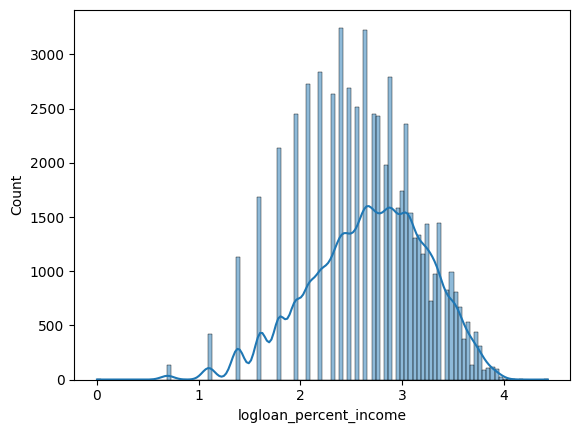

In [48]:
handle_skewness(df,'loan_percent_income')

skewness:  -0.45868351878105695  kurtosis:  0.17014032459621786


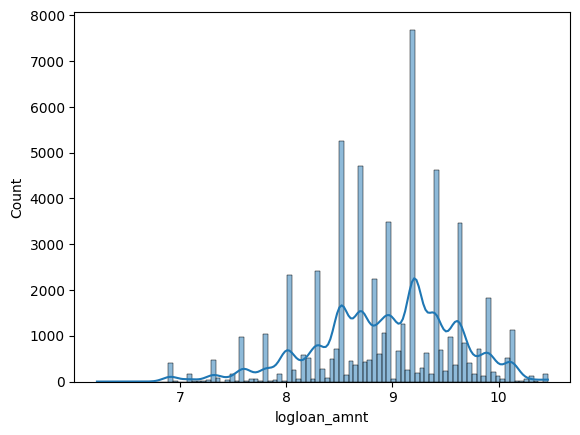

In [54]:
handle_skewness(df,'loan_amnt') 

In [9]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess_data(df, columns, method='z_score', transform='log', scale='standard'):
    """
    Preprocess the given DataFrame to handle outliers, skewness, and kurtosis.

    Parameters:
    - df: pd.DataFrame - Input DataFrame.
    - columns: list - List of column names to preprocess.
    - method: str - Method to identify outliers ('z_score' or 'IQR').
    - transform: str - Transformation to apply ('log', 'sqrt', 'boxcox', or 'none').
    - scale: str - Scaling method ('standard', 'minmax', or 'none').

    Returns:
    - pd.DataFrame - Preprocessed DataFrame.
    """

    df_copy = df.copy()

    # Step 1: Handle Outliers
    for column in columns:
        if method == 'z_score':
            # Identify outliers using Z-score
            z_scores = np.abs(stats.zscore(df_copy[column]))
            df_copy = df_copy[z_scores < 3]  # Adjust the threshold as needed
        elif method == 'IQR':
            # Identify outliers using IQR
            Q1 = df_copy[column].quantile(0.25)
            Q3 = df_copy[column].quantile(0.75)
            IQR = Q3 - Q1
            df_copy = df_copy[(df_copy[column] >= (Q1 - 1.5 * IQR)) & (df_copy[column] <= (Q3 + 1.5 * IQR))]

    # Step 2: Transform to Handle Skewness and Kurtosis
    for column in columns:
        if transform == 'log':
            df_copy[column] = np.log1p(df_copy[column])
        elif transform == 'sqrt':
            df_copy[column] = np.sqrt(df_copy[column])
        elif transform == 'boxcox':
            df_copy[column], _ = stats.boxcox(df_copy[column] + 1)  # Add 1 to avoid zero values
        elif transform == 'yeo-johnson':
            df_copy[column] = stats.yeojohnson(df_copy[column])[0]  # Yeo-Johnson transformation

    # Step 3: Scale the Data
    if scale == 'standard':
        scaler = StandardScaler()
        df_copy[columns] = scaler.fit_transform(df_copy[columns])
    elif scale == 'minmax':
        scaler = MinMaxScaler()
        df_copy[columns] = scaler.fit_transform(df_copy[columns])

    return df_copy

# Example usage
# df_cleaned = preprocess_data(df, ['person_age', 'person_income', 'loan_amnt'], method='IQR', transform='log', scale='standard')


In [10]:
df2 = preprocess_data(df, ['person_age', 'person_income', 'loan_amnt'], method='IQR', transform='log', scale='standard')

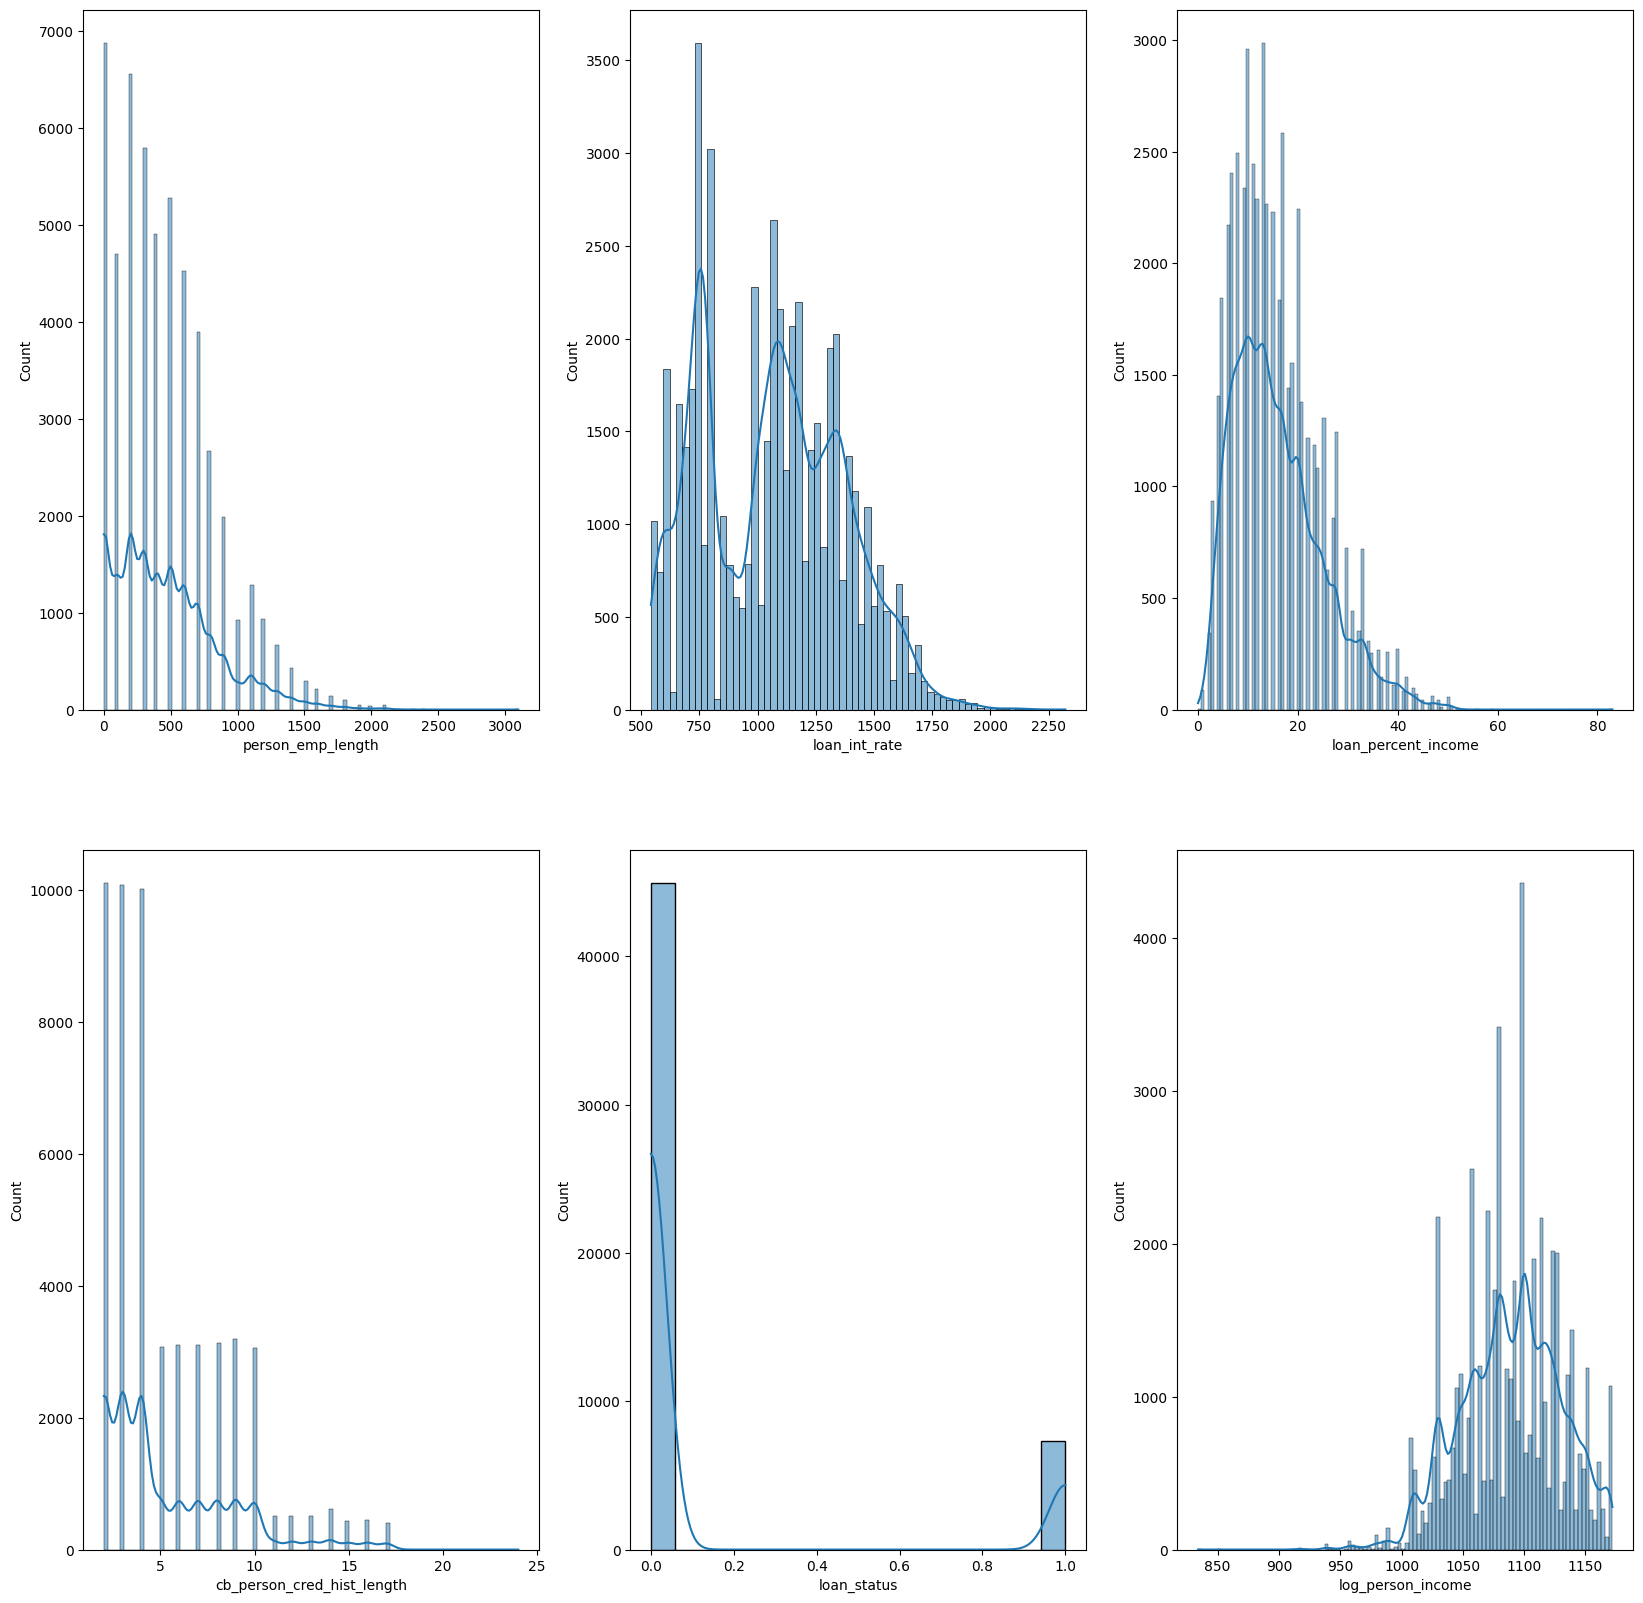

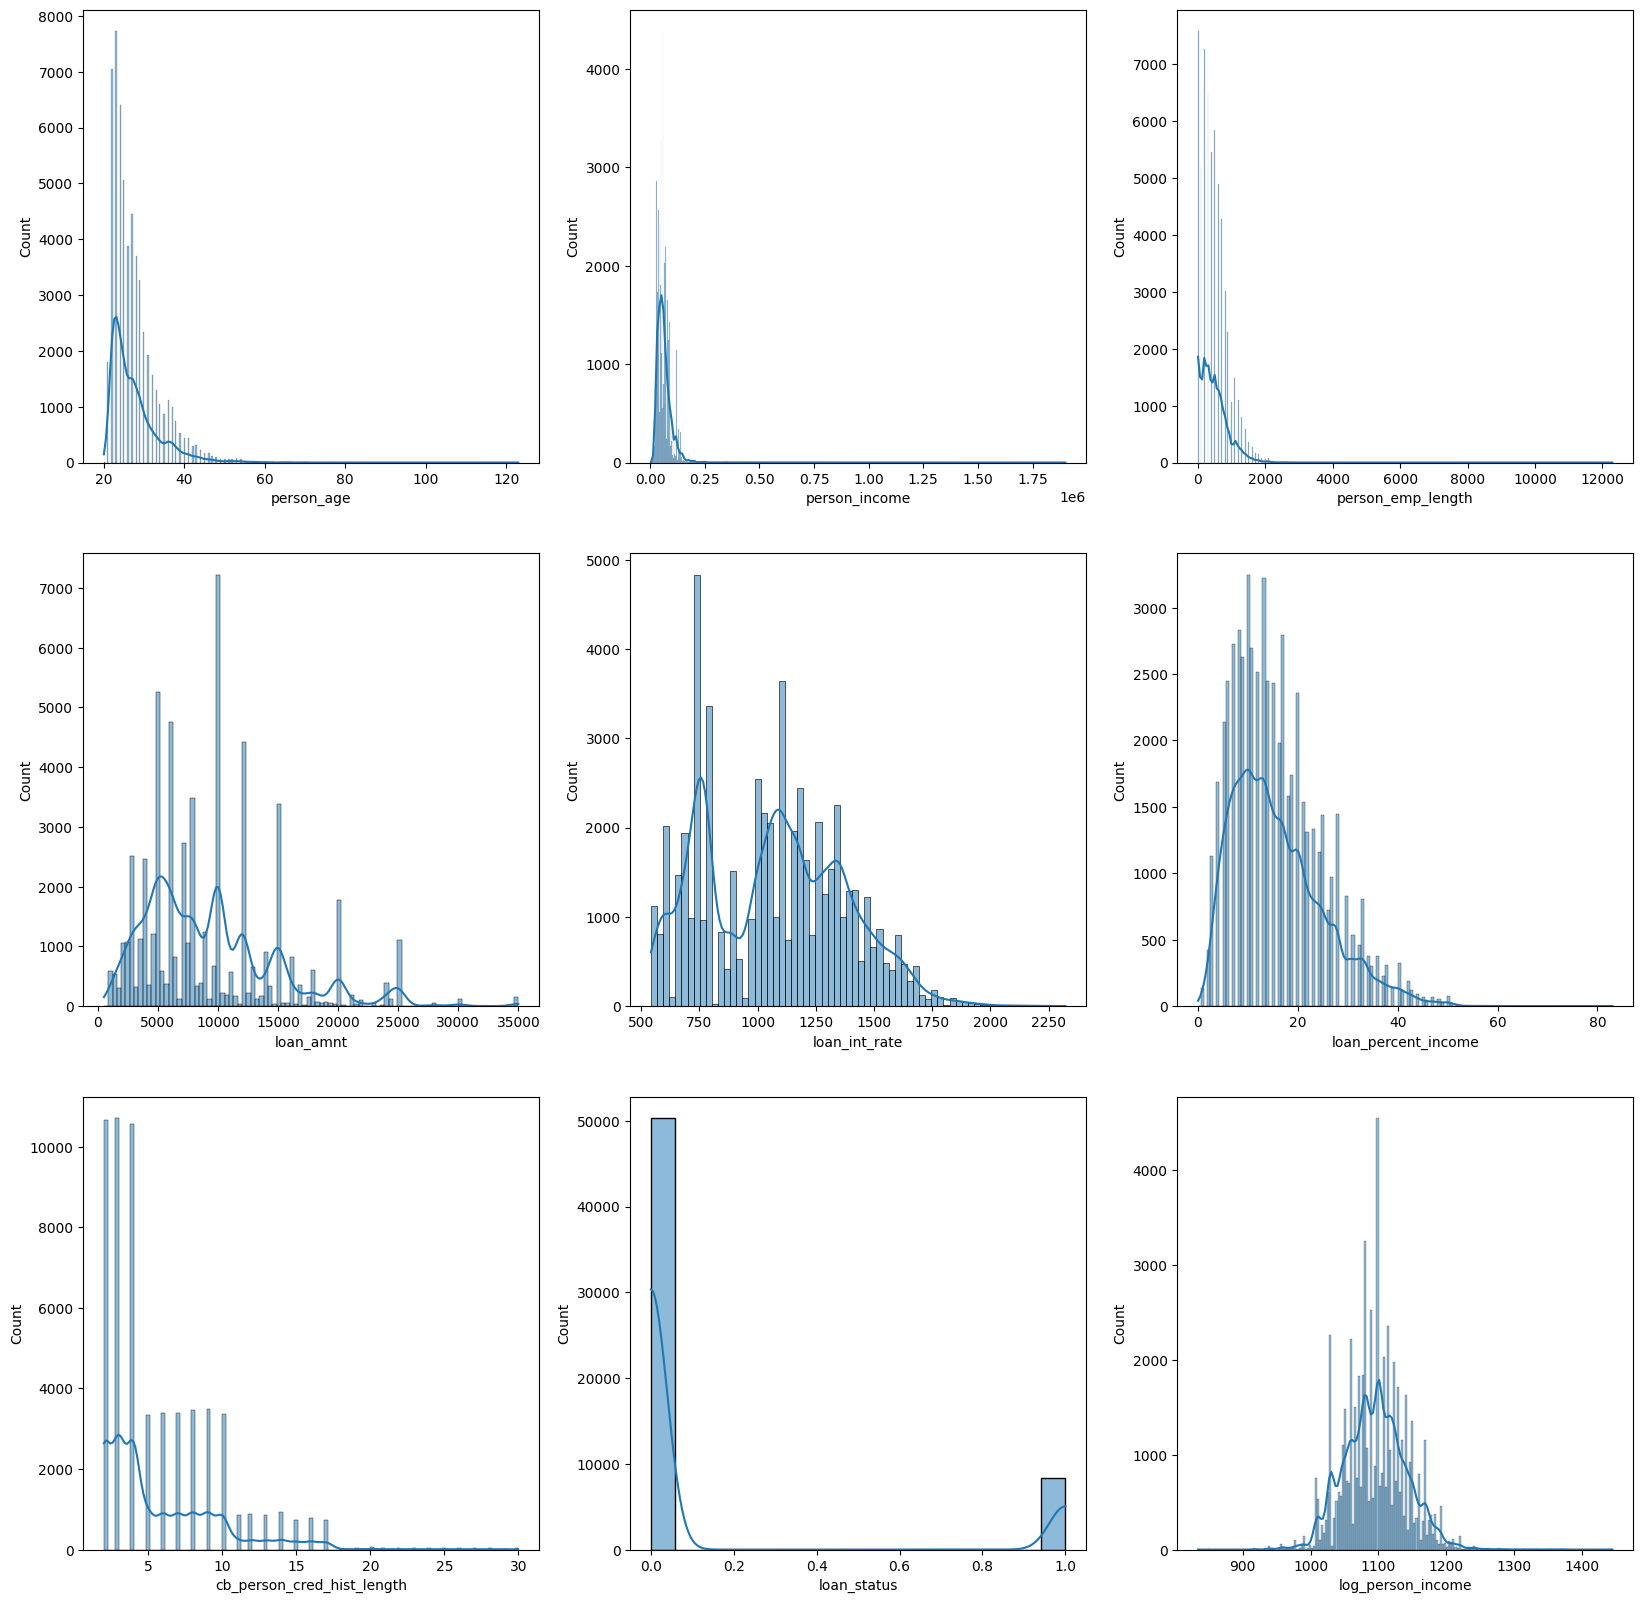

In [20]:
# for col in df.columns:
#     if df[col].dtype != 'object':
#         sns.histplot(df[col])


# draw hist diagram in subplots for each numerical column
num_cols = df2.select_dtypes(include=['int64']).columns
fig, axes = plt.subplots((len(num_cols) + 2) // 3, 3, figsize=(20, 20))
for i, col in enumerate(num_cols):
    sns.histplot(df2[col], ax=axes[i//3, i%3],kde=True)

# save figure
plt.savefig('preprocessed_df.png')

# draw hist diagram in subplots for each numerical column
num_cols = df.select_dtypes(include=['int64']).columns
fig, axes = plt.subplots((len(num_cols) + 2) // 3, 3, figsize=(20, 20))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i//3, i%3],kde=True)

plt.savefig('original_df.png')

# print(df.columns, df2.columns)
# # person_age, person_income, cb_cred_hist_length, 